In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from functools import partial
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.cluster import GaussianCluster
from graspy.embed import MultipleASE, OmnibusEmbed
from graspy.models import SBMEstimator
from graspy.plot import heatmap
from graspy.simulations import er_np, sbm
from joblib import Parallel, delayed
from scipy.stats import ttest_ind
from sklearn.metrics import adjusted_rand_score

from src import generate_binary_sbms

%matplotlib inline

/env/miniconda3/envs/dnd/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [3]:
def estimate_embeddings(X, Y, method):
    """
    Parameters
    ----------
    method : str
        Must be {'mase', 'omni'}
    """
    stacked = np.vstack([X, Y])

    if method == "mase":
        embedder = MultipleASE(2)
        embeddings = embedder.fit_transform(stacked)
    elif method == "omni":
        embedder = OmnibusEmbed(2)
        embeddings = embedder.fit_transform(stacked).mean(axis=0)
    else:
        assert ValueError("Invalid embedding method")

    return embeddings


def estimate_community(embeddings, n_clusters):
    predicted_labels = (
        GaussianCluster(n_clusters, n_clusters, "all").fit_predict(embeddings) + 1
    )

    # ari = adjusted_rand_score(true_labels, predicted_labels)
    return predicted_labels


def estimate_b(X, Y, labels):
    pop_1_block_p = np.array([SBMEstimator(False).fit(x, labels).block_p_ for x in X])
    pop_2_block_p = np.array([SBMEstimator(False).fit(x, labels).block_p_ for x in Y])

    return pop_1_block_p, pop_2_block_p


def compute_ttest(pop1, pop2):
    statistics, pvals = ttest_ind(pop1, pop2, axis=0)

    return pvals

<IPython.core.display.Javascript object>

In [4]:
def run_experiment(m, block_1, block_2, p, delta, n_clusters, reps):
    total_n = block_1 + block_2
    r, c = np.triu_indices(total_n, k=1)

    omni_res = np.zeros((reps, len(n_clusters), 2))
    mase_res = np.zeros((reps, len(n_clusters), 2))

    for i in np.arange(reps).astype(int):
        pop1, pop2, true_labels = generate_binary_sbms(
            m=m, block_1=block_1, block_2=block_2, p=p, delta=delta
        )
        pop1_edges = pop1[:, r, c]
        pop2_edges = pop2[:, r, c]
        true_edges = (true_labels[:, None] + true_labels[None, :])[r, c]

        for method in ["mase", "omni"]:
            embeddings = estimate_embeddings(pop1, pop2, method)

            for k_idx, k in enumerate(n_clusters):
                predicted_labels = estimate_community(embeddings, k)
                predicted_edge_labels = (
                    predicted_labels[:, None] * predicted_labels[None, :]
                )[
                    r, c
                ]  # vectorize to uppper triu
                sig_edges = np.zeros((total_n, total_n))[r, c]

                for cluster_label in np.unique(predicted_edge_labels):
                    tmp_labels = predicted_edge_labels == cluster_label
                    statistics, pvals = ttest_ind(
                        pop1_edges[:, tmp_labels].ravel(),
                        pop2_edges[:, tmp_labels].ravel(),
                    )
                    if pvals <= 0.05:
                        sig_edges[tmp_labels] = 1

                prec = (sig_edges[true_edges == 0]).sum() / sig_edges.sum()
                recall = (sig_edges[true_edges == 0]).sum() / (true_edges == 0).sum()

                if method == "mase":
                    mase_res[i, k_idx, :] = (prec, recall)
                else:
                    omni_res[i, k_idx, :] = (prec, recall)

    omni_res = omni_res.mean(axis=0).reshape(-1)
    mase_res = mase_res.mean(axis=0).reshape(-1)

    to_append = [m, p, delta, *omni_res, *mase_res]
    return to_append

<IPython.core.display.Javascript object>

In [5]:
block_1 = 25  # different probability
block_2 = 25
n_clusters = range(2, 11, 2)
p = 0.5
reps = 100
spacing = 50
deltas = np.linspace(0, 1 - p, spacing + 1)
ms = np.linspace(0, 250, spacing + 1)[1:]

partial_func = partial(
    run_experiment,
    block_1=block_1,
    block_2=block_2,
    p=p,
    n_clusters=n_clusters,
    reps=reps,
)
args = [dict(m=m, delta=delta) for m, delta in product(ms, deltas)][::2]

<IPython.core.display.Javascript object>

In [ ]:
res = Parallel(n_jobs=-1, verbose=7)(delayed(partial_func)(**arg) for arg in args)

cols = [
    "m",
    "p",
    "delta",
    *[f"omni_{metric}_{k}" for k in n_clusters for metric in ["precision", "recall"]],
    *[f"mase_{metric}_{k}" for k in n_clusters for metric in ["precision", "recall"]],
]
res_df = pd.DataFrame(res, columns=cols)

res_df.to_csv(f"./results/20200222_correct_nodes_1.csv", index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


## Figures

In [7]:
res_df = pd.read_csv("./results/20200204_results.csv")

res_df.head()

,p,delta,m,omni_power_1,omni_power_2,omni_power_3,mase_power_1,mase_power_2,mase_power_3
0,0.5,0.01,10.0,0.06,0.06,0.02,0.05,0.06,0.05
1,0.5,0.02,10.0,0.07,0.03,0.02,0.03,0.07,0.02
2,0.5,0.03,10.0,0.02,0.02,0.01,0.04,0.07,0.07
3,0.5,0.04,10.0,0.06,0.05,0.05,0.07,0.02,0.06
4,0.5,0.05,10.0,0.00,0.07,0.02,0.04,0.06,0.07


<IPython.core.display.Javascript object>

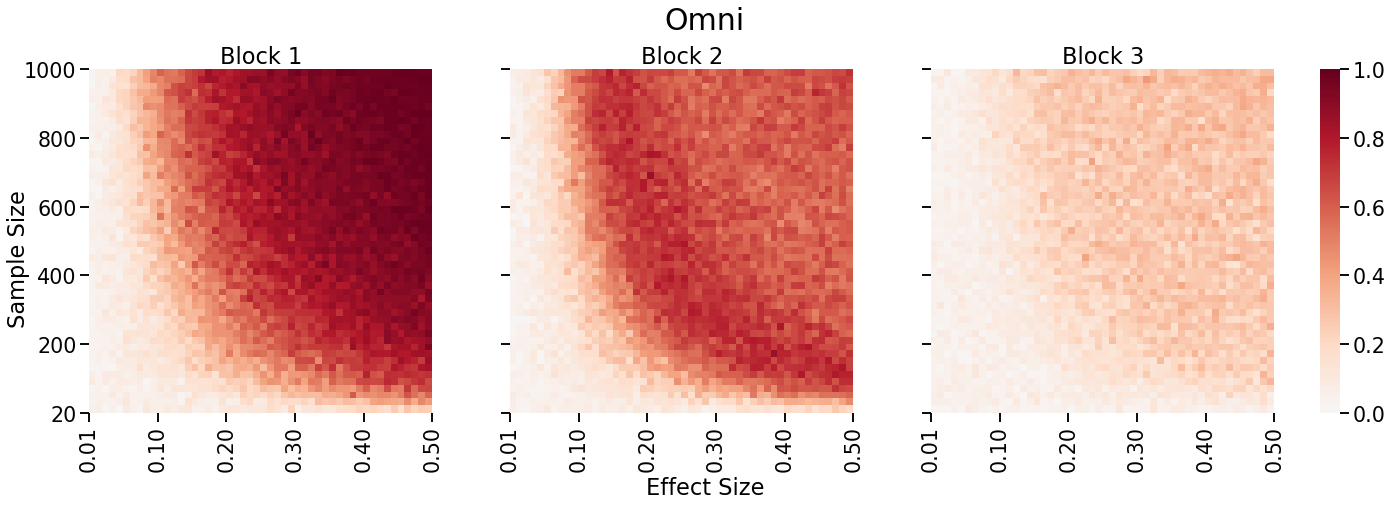

<IPython.core.display.Javascript object>

In [44]:
fmt = lambda x: "{:.2f}".format(x)

p = 0.5
spacing = 50
deltas = np.linspace(0, 1 - p, spacing + 1)[::10]
deltas[0] += 0.01
ms = np.linspace(0, 500, spacing + 1)[::10] * 2
ms[0] += 20

with sns.plotting_context("talk", font_scale=1.25):
    fig, ax = plt.subplots(
        1,
        4,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        figsize=(19, 6),
        constrained_layout=True,
    )

    for i in range(3):
        sns.heatmap(
            np.flipud(res_df[f"omni_power_{i+1}"].values.reshape(spacing, -1)),
            ax=ax[i],
            square=True,
            center=0,
            cmap="RdBu_r",
            cbar_kws=dict(shrink=0.7),
            xticklabels=[fmt(d) for d in deltas],
            yticklabels=["{:.0f}".format(m) for m in ms],
            cbar_ax=ax[-1],
            vmin=0,
            vmax=1,
        )
        ax[i].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 10))
        ax[i].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 10)[::-1])
        if i != 0:
            ax[i].yaxis.set_major_formatter(plt.NullFormatter())
        ax[i].set_title(f"Block {i+1}")

    fig.text(-0.01, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Effect Size", va="center", ha="center")
    fig.text(0.5, 1.05, "Omni", va="center", ha="center", fontsize=30)

    fig.savefig("./figures/20200204_omni_power.png", dpi=300, bbox_inches="tight")
    fig.savefig("./figures/20200204_omni_power.pdf", bbox_inches="tight")

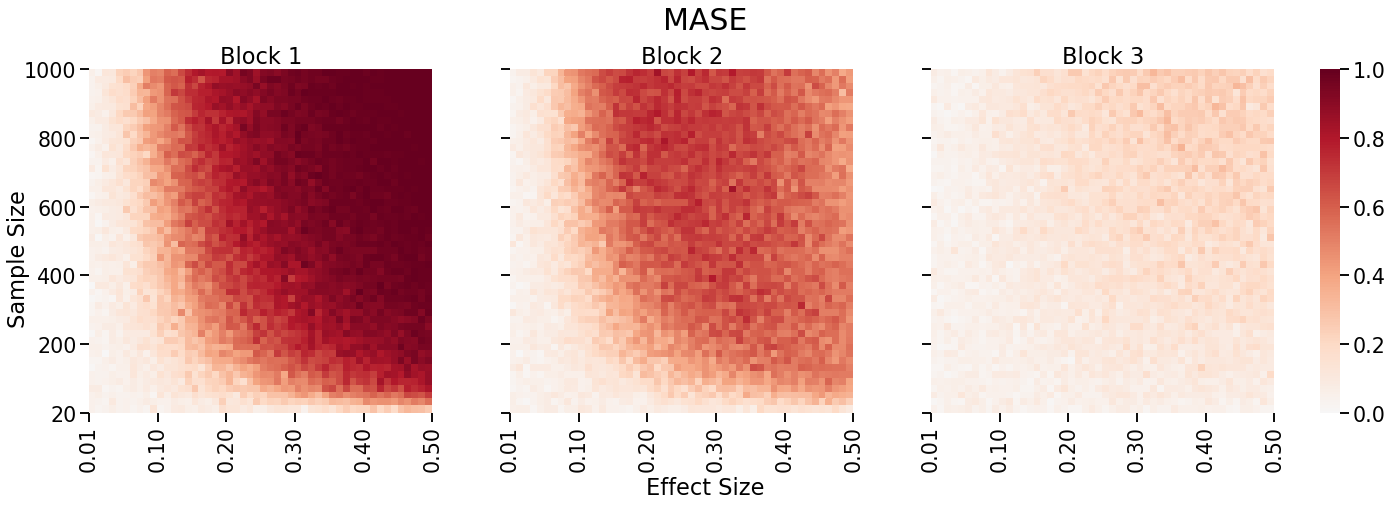

<IPython.core.display.Javascript object>

In [45]:
fmt = lambda x: "{:.2f}".format(x)

p = 0.5
spacing = 50
deltas = np.linspace(0, 1 - p, spacing + 1)[::10]
deltas[0] += 0.01
ms = np.linspace(0, 500, spacing + 1)[::10] * 2
ms[0] += 20

with sns.plotting_context("talk", font_scale=1.25):
    fig, ax = plt.subplots(
        1,
        4,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        figsize=(19, 6),
        constrained_layout=True,
    )

    for i in range(3):
        sns.heatmap(
            np.flipud(res_df[f"mase_power_{i+1}"].values.reshape(spacing, -1)),
            ax=ax[i],
            square=True,
            center=0,
            cmap="RdBu_r",
            cbar_kws=dict(shrink=0.7),
            xticklabels=[fmt(d) for d in deltas],
            yticklabels=["{:.0f}".format(m) for m in ms],
            cbar_ax=ax[-1],
            vmin=0,
            vmax=1,
        )
        ax[i].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 10))
        ax[i].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 10)[::-1])
        if i != 0:
            ax[i].yaxis.set_major_formatter(plt.NullFormatter())
        ax[i].set_title(f"Block {i+1}")

    fig.text(-0.01, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Effect Size", va="center", ha="center")
    fig.text(0.5, 1.05, "MASE", va="center", ha="center", fontsize=30)

    fig.savefig("./figures/20200204_mase_power.png", dpi=300, bbox_inches="tight")
    fig.savefig("./figures/20200204_mase_power.pdf", bbox_inches="tight")

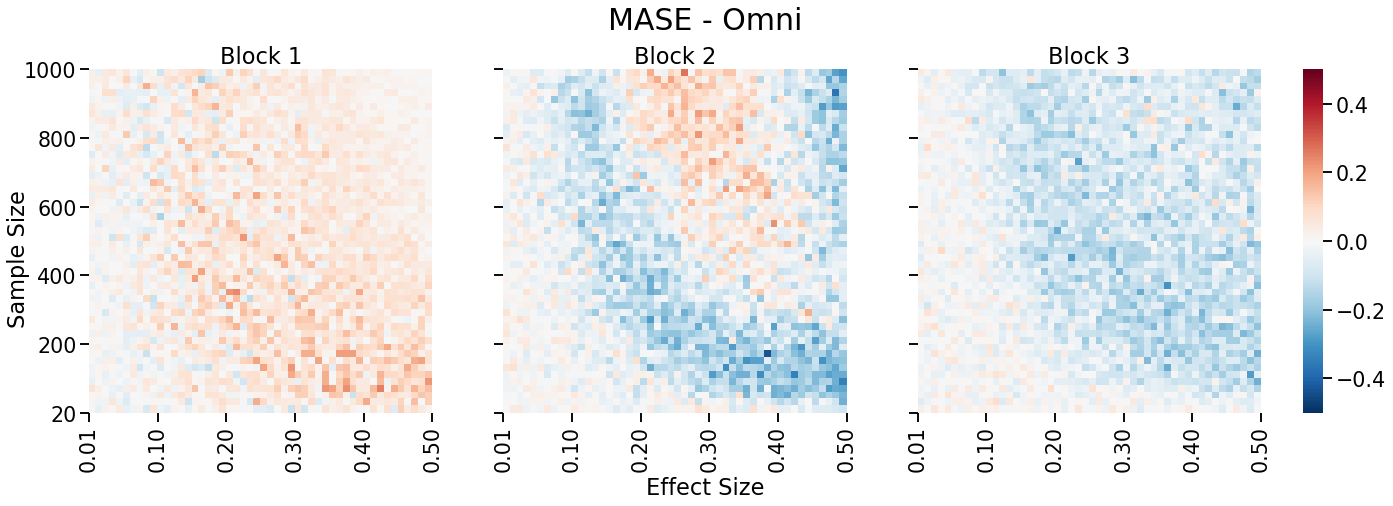

<IPython.core.display.Javascript object>

In [11]:
fmt = lambda x: "{:.2f}".format(x)

p = 0.5
spacing = 50
deltas = np.linspace(0, 1 - p, spacing + 1)[::10]
deltas[0] += 0.01
ms = np.linspace(0, 500, spacing + 1)[::10] * 2
ms[0] += 20

with sns.plotting_context("talk", font_scale=1.25):
    fig, ax = plt.subplots(
        1,
        4,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        figsize=(19, 6),
        constrained_layout=True,
    )

    for i in range(3):
        sns.heatmap(
            np.flipud(
                (
                    res_df[f"mase_power_{i+1}"] - res_df[f"omni_power_{i+1}"]
                ).values.reshape(spacing, -1)
            ),
            ax=ax[i],
            square=True,
            center=0,
            cmap="RdBu_r",
            cbar_kws=dict(shrink=0.7),
            xticklabels=[fmt(d) for d in deltas],
            yticklabels=["{:.0f}".format(m) for m in ms],
            cbar_ax=ax[-1],
            vmin=-0.5,
            vmax=0.5,
        )
        ax[i].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 10))
        ax[i].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 10)[::-1])
        if i != 0:
            ax[i].yaxis.set_major_formatter(plt.NullFormatter())
        ax[i].set_title(f"Block {i+1}")

    fig.text(-0.01, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Effect Size", va="center", ha="center")
    fig.text(0.5, 1.05, "MASE - Omni", va="center", ha="center", fontsize=30)

    fig.savefig("./figures/20200204_diff_power.png", dpi=300, bbox_inches="tight")
    fig.savefig("./figures/20200204_diff_power.pdf", bbox_inches="tight")